# auto regressive transformer https://fast-transformers.github.io/

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change. But blacklist large modules
%load_ext autoreload
%autoreload 2
%aimport -pandas
%aimport -torch
%aimport -numpy
%aimport -matplotlib
%aimport -dask
%aimport -functools
%aimport -tqdm
%aimport -pytorch_lightning
%matplotlib inline

In [2]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:

from neural_processes.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from neural_processes.plot import plot_from_loader

from neural_processes.dict_logger import DictLogger
from neural_processes.utils import PyTorchLightningPruningCallback
from neural_processes.train import main, objective, add_number, run_trial

from neural_processes.models.neural_process.lightning import PL_NP, PL_ANP, PL_ANPRNN

from neural_processes.models.transformer import PL_Transformer
from neural_processes.models.transformer_seq2seq import TransformerSeq2Seq_PL
from neural_processes.models.transformer_seq2seq_autor import TransformerSeq2SeqAutoR_PL
from neural_processes.models.transformer_autor import TransformerAutoR_PL

from neural_processes.models.lstm_seqseq import LSTMSeq2Seq_PL
from neural_processes.models.lstm_std import LSTM_PL_STD

In [5]:
# Params
device='cuda'
use_logy=False

In [6]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("autoregt.ipynb")

# Load kaggle smart meter data

In [7]:
df_train, df_test = get_smartmeter_df(
    indir=Path('./data/smart-meters-in-london'), 
#     use_logy=False, 
#     max_files=40
)

In [8]:
data_train = SmartMeterDataSet(
    df_train, 200, 400)
b = data_train[10]
b = collate_fns(110, 210, sample=True)([b])
[bb.shape for bb in b]

[torch.Size([1, 103, 17]),
 torch.Size([1, 103, 1]),
 torch.Size([1, 181, 17]),
 torch.Size([1, 181, 1])]

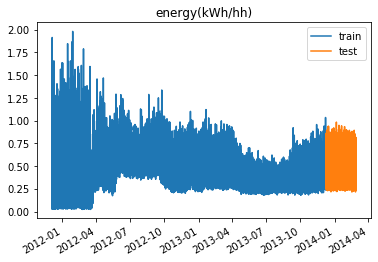

In [9]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Experiments

In [10]:
# Summarize results


def summarize_results(results):
    result_dfs = []
    for k in results:
        v = results[k]
        df = pd.DataFrame(v).mean()
        df.name = k+'_mean'
        df['n'] = len(v)
        result_dfs.append(df)

#         df = pd.DataFrame(v).std()
#         df.name = k+'_std'
#         df['n'] = len(v)
#         result_dfs.append(df)

    if len(result_dfs)==0:
        return None
    result_df = pd.concat(result_dfs, 1).T
    
    return result_df.sort_values('agg_test_score').T

In [11]:
default_user_attrs = {
    'x_dim': 17,
    'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 48 * 3,
    'num_extra_target': 48 * 3,
    'max_nb_epochs': 40,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 24,
    'patience': 2,
    'max_epoch_steps': 32 * 600,
    "nan_value": 0,
}
N = 3

experiments = [
    dict(
        name="TransformerAutoR_PL",
        PL_MODEL_CLS=TransformerAutoR_PL,
        params={
            'learning_rate': 3e-5,
            'nlayers': 12,
            'use_lstm': False,
            'hidden_out_size_power': 5,
            "attention_dropout": 0.0,
            "dropout": 0.0,
            
        },
    ),
]
number = -1
results = collections.defaultdict(list)

INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`


EarlyStopping mode auto is unknown, fallback to auto mode.


INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.


EarlyStopping mode set to min for monitoring val_loss.


INFO:lightning:EarlyStopping mode set to min for monitoring val_loss.


GPU available: True, used: True


INFO:lightning:GPU available: True, used: True


TPU available: False, using: 0 TPU cores


INFO:lightning:TPU available: False, using: 0 TPU cores


CUDA_VISIBLE_DEVICES: [0]


INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:predict_heading2:trial number=-1209 name=TransformerAutoR_PL, trial=<optuna.trial.FixedTrial object at 0x7f47eb6eb6a0> params={'learning_rate': 3e-05, 'attention_dropout': 0.0, 'dropout': 0.0, 'hidden_out_size_power': 5, 'nhead_power': 3, 'nlayers': 12, 'use_lstm': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 40, 'num_workers': 3, 'num_extra_target': 144, 'vis_i': '670', 'num_context': 144, 'input_size': 18, 'input_size_decoder': 17, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'nan_value': 0, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}



  | Name   | Type                | Params
-----------------------------------------------
0 | _model | TransformerAutoRNet | 3 M   


INFO:lightning:
  | Name   | Type                | Params
-----------------------------------------------
0 | _model | TransformerAutoRNet | 3 M   


INFO:predict_heading2:val step=0, outputs={'val_loss_p': tensor(0.6255), 'val_loss_mse': tensor(0.1070), 'val_loss': tensor(0.6255), 'val_loss_p_weighted': tensor(0.0950)}


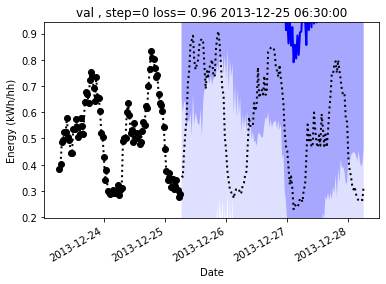

INFO:predict_heading2:val step=799, outputs={'val_loss_p': tensor(-0.6810), 'val_loss_mse': tensor(0.0150), 'val_loss': tensor(-0.6810), 'val_loss_p_weighted': tensor(-0.1060)}


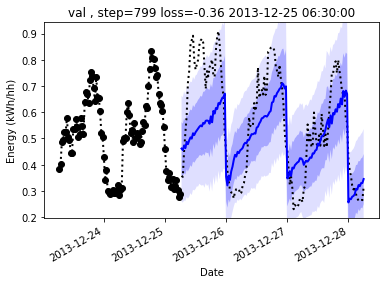

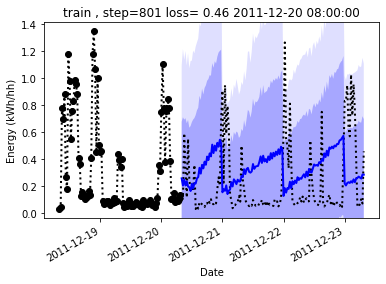

INFO:predict_heading2:train step=801, outputs={'train_loss': tensor(-0.5413), 'train_loss_p_weighted': tensor(-0.0907), 'train_loss_mse': tensor(0.0306), 'train_loss_p': tensor(-0.5413)}


In [ ]:
# TEST
exp=experiments[0]
trial, trainer, model = run_trial(
    user_attrs = default_user_attrs,
    **exp)

In [ ]:
for i in range(N):
    for exp in experiments:
        print(i, exp)
        trial, trainer, model = run_trial(
            user_attrs = default_user_attrs,
            number=number*i*100-1000,
            **exp)

        name = trainer.logger.name
        r=trainer.logger.metrics[-1]
        if 'agg_test_score' in r:
            results[name].append(r)

            display(summarize_results(results))

In [ ]:
display(summarize_results(results))

In [ ]:
result_dfs = []
for k in results:
    v = results[k]
    df = pd.DataFrame(v).mean()
    df = pd.concat([pd.DataFrame(v).mean().rename(lambda x:'mean_' + x),
    pd.DataFrame(v).std().rename(lambda x:'std_' + x),
    pd.DataFrame(v).min().rename(lambda x:'min_' + x)])

    df.name = k
    df['n'] = len(v)
    result_dfs.append(df)

#         df = pd.DataFrame(v).std()
#         df.name = k+'_std'
#         df['n'] = len(v)
#         result_dfs.append(df)


result_df = pd.concat(result_dfs, 1).T
result_df.sort_values('min_agg_test_score').T

# Manual exp

In [ ]:
number=None

# Hyperparam

In [ ]:
from neural_processes.train import objective
import argparse 

In [ ]:
optuna_path = Path('./optuna_result2')
optuna_path.mkdir(exist_ok=True)

In [ ]:
for PL_MODEL_CLS in [TransformerSeq2Seq_PL, PL_ANPRNN]:
    name = str(PL_MODEL_CLS.__name__)
    func = functools.partial(objective,
                             PL_MODEL_CLS=PL_MODEL_CLS,
                             name=name,
                             user_attrs=default_user_attrs)

    parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
    parser.add_argument(
        '--pruning',
        '-p',
        action='store_true',
        help='Activate the pruning feature. `MedianPruner` stops unpromising '
        'trials at the early stages of training.')
    args = parser.parse_args(['-p'])

    pruner = optuna.pruners.MedianPruner(
        n_warmup_steps=1,
        n_startup_trials=6) if args.pruning else optuna.pruners.NopPruner()
    pruner = optuna.pruners.PercentilePruner(75.0)

    study = optuna.create_study(direction='minimize',
                                pruner=pruner,
                                storage=f'sqlite:///{optuna_path}/{name}.db',
                                study_name=name,
                                load_if_exists=True)

#     1/0
    study.optimize(func=func,
                   n_trials=200,
                   timeout=pd.Timedelta('0.5d').total_seconds())

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    # shutil.rmtree(MODEL_DIR)

    df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
    print(df.sort_values('value'))

In [ ]:
PL_MODEL_CLS

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')